6/14 (Fri)

---

# Plot Graphs of Experiment Results

This notebook draws graphs of experiment results for the paper.
I exploratory drew graphs of the following results.

1. Inter-Coder Reliability
    1. Cohen's Kappa & 95% CI. (for Disfluency Detection & Pause Location Classification)
    2. Precision, Recall & F1 Score
2. Correlation Analyses
3. Automated Scoring
    1. R2
    2. Pearson's Correlation Coefficients
    3. Dominance Analysis

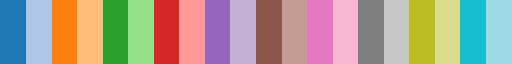

In [1]:
from typing import *
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.legend_handler import HandlerTuple

DATA_DIR = Path("/home/matsuura/Development/app/feature_extraction_api/experiment/data")
TASK = ["Arg_Oly", "Cartoon", "RtSwithoutRAA", "RtSwithRAA", "WoZ_Interview"]

TASK_2_REPORTNAME = {
    "Arg_Oly": "Argumentative", 
    "Cartoon": "Picture Narrative", 
    "RtSwithoutRAA": "RtoS", 
    "RtSwithRAA": "RwLtoS", 
    "WoZ_Interview": "Interview"
}

TARGET_UF_MEASURES = [
    "articulation_rate", "mid_clause_pause_ratio", "end_clause_pause_ratio",
    "mid_clause_p-dur", "end_clause_p-dur", "pause_ratio", "mean_pause_duration",
    "dysfluency_ratio", "speech_rate", "mean_length_of_run"
]

MEEASURE_2_REPORTNAME = {
    "articulation_rate": "Articulation Rate",
    "mid_clause_pause_ratio": "Mid-Clause Pause Ratio",
    "end_clause_pause_ratio": "End-Clause Pause Ratio",
    "mid_clause_p-dur": "Mid-Clause Pause Duration",
    "end_clause_p-dur": "End-Clause Pause Duration", 
    "pause_ratio": "Pause Ratio", 
    "mean_pause_duration": "Mean Pause Duration",
    "dysfluency_ratio": "Disfluency Ratio", 
    "speech_rate": "Speech Rate", 
    "mean_length_of_run": "Mean Length of Run"
}

COLOR_MAP = plt.get_cmap('tab20')
COLOR_MAP

## 1. Utility Functions

In [2]:
def set_grid(ax: plt.Axes) -> plt.Axes:
    ax.grid(which="major", lw=0.7)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.grid(which="minor", lw=0.4)

    return ax

## 2. Cohen's Kappa

In [3]:
df_kappa_disfl = pd.read_csv(DATA_DIR / "kappa_disfl_detection.csv", index_col=0)
df_kappa_pl = pd.read_csv(DATA_DIR / "kappa_pause_loc_detection.csv", index_col=0)

In [4]:
def draw_vertical_kappa_plots(
        df_kappa: pd.DataFrame,
        cutoff: Optional[float] =None,
        ax: Optional[plt.Axes] =None,
) -> plt.Axes:
    
    if ax is None:
        ax = plt.axes()
    
    if cutoff:
        ax.vlines(cutoff, 0, 6, colors=COLOR_MAP(6), linestyles="dotted")

    y = 1
    y_labels = []
    for trial_name in reversed(df_kappa.index):
        is_overall_eval = str(trial_name).endswith("00All")
        if not is_overall_eval:
            continue

        task_name = trial_name.removesuffix("_00All")

        kappa = df_kappa.at[trial_name, "Kappa"]        
        ci = df_kappa.at[trial_name, "95% CI"]
        # ci[1:-1] は [0.671, 0.707] の括弧を取る処理，.split(", ") は2つの値をリストへ分割
        lower_boundary, upper_boundary = [float(boundary) for boundary in ci[1:-1].split(", ")]
        
        ax.scatter(kappa, y, color=COLOR_MAP(0))
        ax.hlines(y, lower_boundary, upper_boundary, color=COLOR_MAP(0))

        y_labels.append(TASK_2_REPORTNAME[task_name])
        y += 1

    ax.set_yticks(range(1, len(y_labels) + 1))
    ax.set_yticklabels(y_labels)

    ax.set_xlabel("Cohen's Kappa")
    ax.set_ylabel("Task")

    return ax

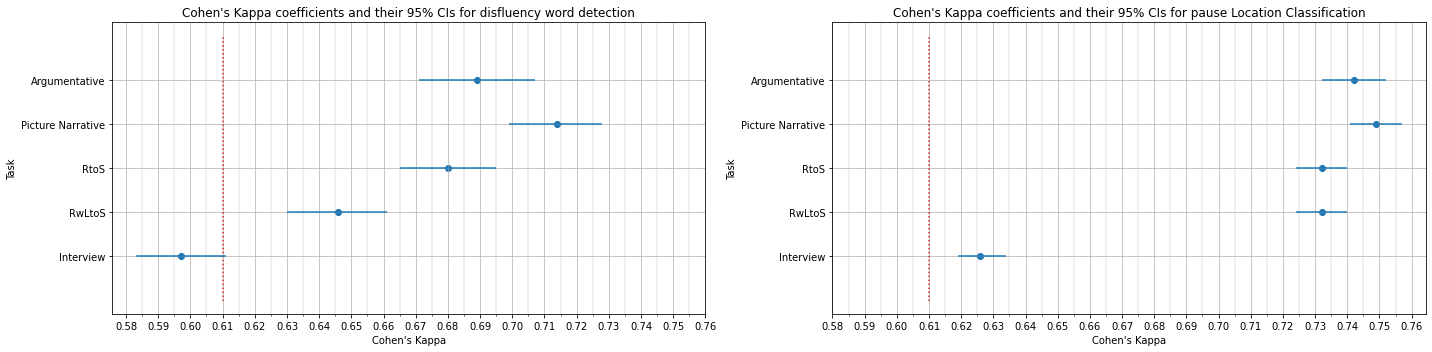

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0] = draw_vertical_kappa_plots(df_kappa_disfl, cutoff=0.61, ax=axes[0])
axes[0].set_title("Cohen's Kappa coefficients and their 95% CIs for disfluency word detection")

axes[1] = draw_vertical_kappa_plots(df_kappa_pl, cutoff=0.61, ax=axes[1])
axes[1].set_title("Cohen's Kappa coefficients and their 95% CIs for pause Location Classification")

for ax in axes:
    ax.set_xticks(np.arange(0.58, 0.76, 0.01))
    ax = set_grid(ax)

fig.tight_layout()
plt.show()

In [6]:
def draw_kappa_bar_plots(
        df_kappa: pd.DataFrame,
        n_groups: int=4,
        cutoff: Optional[float] =None,
        ax: Optional[plt.Axes] =None
) -> plt.Axes:
    if ax is None:
        ax = plt.axes()

    colors = []
    for i in range(n_groups):
        tab20_color_id = 2 * i
        if tab20_color_id > 5:
            tab20_color_id += 2
        colors.append(COLOR_MAP(tab20_color_id))

    if cutoff:
        ax.hlines(cutoff, 0, n_groups + 2, colors=COLOR_MAP(6), linestyles="dashed", lw=1.5)

    for x, task in enumerate(TASK, start=1):
        mask_task = df_kappa.index.str.startswith(task)
        df_kappa_mask = df_kappa[mask_task].sort_index()

        kappa = df_kappa_mask["Kappa"].to_numpy()
        lower_kappa = df_kappa_mask["95% CI"].apply(lambda ci: float(ci[1:5])).to_numpy()
        lower_kappa = df_kappa_mask["95% CI"].apply(lambda ci: float(ci[1:5])).to_numpy()
        kappa_error = kappa - lower_kappa

        n = len(kappa)
        width = 0.8 / n

        if n % 2 == 0:
            delta = -(n / 2) * width - (0.5 / n)
        else: 
            delta = -(n / 2 - 0.5) * width

        rects = []
        for i, k in enumerate(kappa):
            delta += width

            p1 = ax.errorbar(
                x + delta, k, yerr=kappa_error[i], fmt="o", lw=2, capsize=6, capthick=1.6, color=colors[i]          
            )
            rects.append(p1)

    ax.set_xticks(range(1, len(TASK) + 1))
    ax.set_xticklabels([TASK_2_REPORTNAME[task] for task in TASK])

    ax.set_xlabel("Task", fontsize=15)
    ax.set_ylabel("Cohen's Kappa", fontsize=15)

    return ax, rects

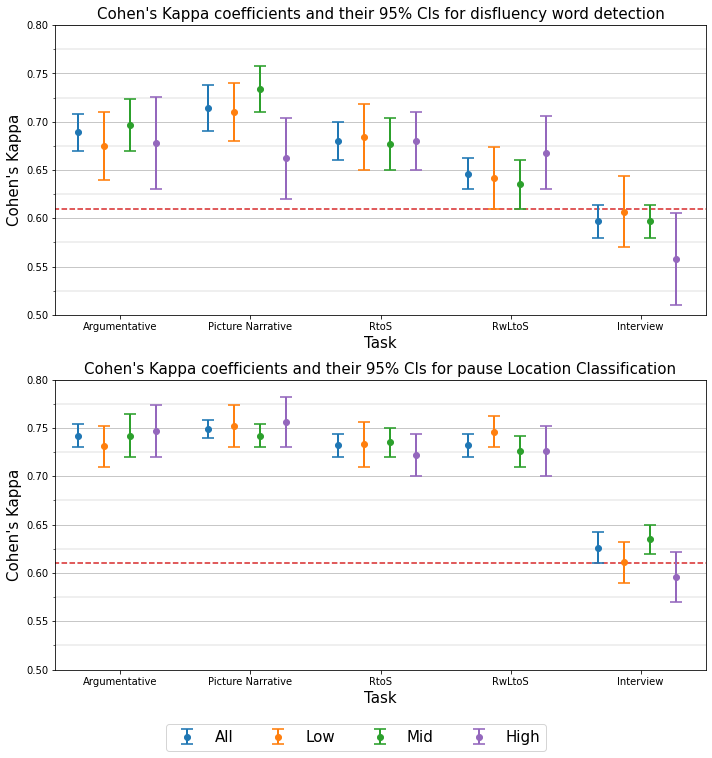

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes[0], rects = draw_kappa_bar_plots(df_kappa_disfl, cutoff=0.61, ax=axes[0])
axes[0].set_title("Cohen's Kappa coefficients and their 95% CIs for disfluency word detection", fontsize=15)

axes[1], rects = draw_kappa_bar_plots(df_kappa_pl, cutoff=0.61, ax=axes[1])
axes[1].set_title("Cohen's Kappa coefficients and their 95% CIs for pause Location Classification", fontsize=15)

for ax in axes:
    ax.set_yticks(np.arange(0, 1.1, 0.05))
    ax.grid(which="major", axis="y", lw=0.7)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.grid(which="minor", axis="y", lw=0.4)
    ax.set_axisbelow(True)

    ax.set_ylim(0.5, 0.8)
    ax.set_xlim(0.5, 5.5)

groups = ["All", "Low", "Mid", "High"]
fig.legend(
    rects, groups, loc="upper center", bbox_to_anchor=(0.5, 0.0), 
    ncol=4, handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15
)

fig.tight_layout()
plt.show()

## 3. Precision, Recall, F1 Score

In [8]:
df_cfmx_disl = pd.read_csv(DATA_DIR / "cfmx_disfl_detection.csv", index_col=0)
df_cfmx_pl = pd.read_csv(DATA_DIR / "cfmx_pause_loc_detection.csv", index_col=0)

In [9]:
def draw_cfmx_bar_plot(
        df_cfmx: pd.DataFrame,
        task: str,
        target_col: str,
        n_groups: int=4,
        ax: Optional[plt.Axes] =None
) -> plt.Axes:
    if ax is None:
        ax = plt.axes()

    colors = []
    for i in range(n_groups):
        tab20_color_id = 2 * i
        if tab20_color_id > 5:
            tab20_color_id += 2
        colors.append(COLOR_MAP(tab20_color_id))

    mask_task = df_cfmx.index.str.startswith(task)
    df_cfmx_task = df_cfmx[mask_task].sort_index()
    x = np.arange(n_groups)
    metrix = df_cfmx_task[target_col].to_numpy()

    rects = ax.bar(
        x, metrix, width=0.8, 
        align="center", color=colors, alpha=0.8
    )

    for rect in rects:
        height = rect.get_height()   
        ax.annotate(f"{height:.03f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom",
                    fontsize=12)

    return ax, rects

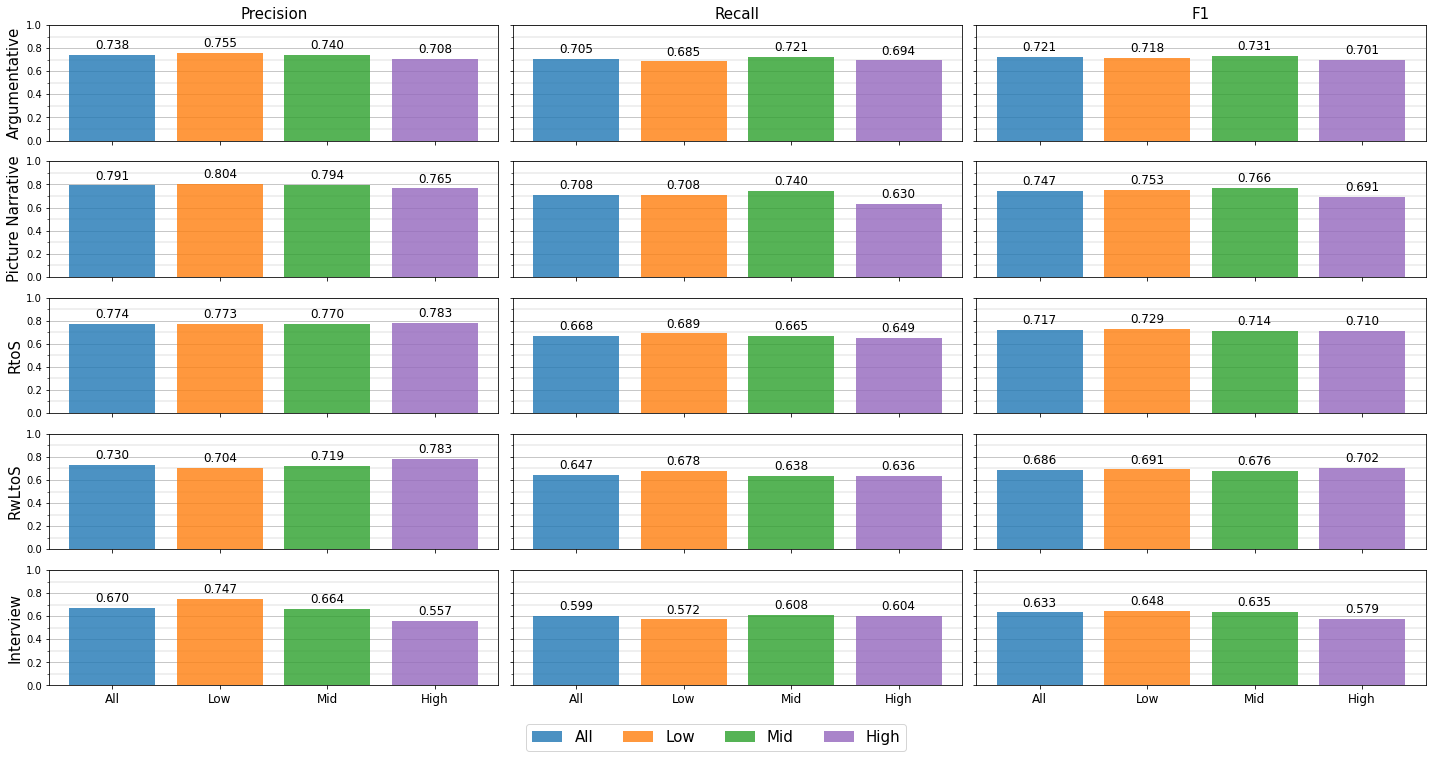

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

metrics = {"P_disfl": "Precision", "R_disfl": "Recall", "F1_disfl": "F1"}
groups = ["All", "Low", "Mid", "High"]

for col_id, metrix in enumerate(metrics.keys()):
    for row_id, task in enumerate(TASK):
        ax = axes[row_id][col_id]

        ax, rects = draw_cfmx_bar_plot(df_cfmx_disl, task, metrix, ax=ax)

        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(groups, fontsize=12)

        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.grid(which="major", axis="y", lw=0.7)
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.grid(which="minor", axis="y", lw=0.4)
        ax.set_axisbelow(True)

        if col_id == 0:
            ax.set_ylabel(TASK_2_REPORTNAME[task], fontsize=15)
        else:
            ax.tick_params(labelleft=False)

        if row_id == 0:
            ax.set_title(metrics[metrix], fontsize=15)

        if row_id < len(TASK) - 1:
            ax.tick_params(labelbottom=False)

groups = ["All", "Low", "Mid", "High"]
fig.legend(
    rects, groups, loc="upper center", bbox_to_anchor=(0.5, 0.0), 
    ncol=4, handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15
)

fig.tight_layout()
plt.show()

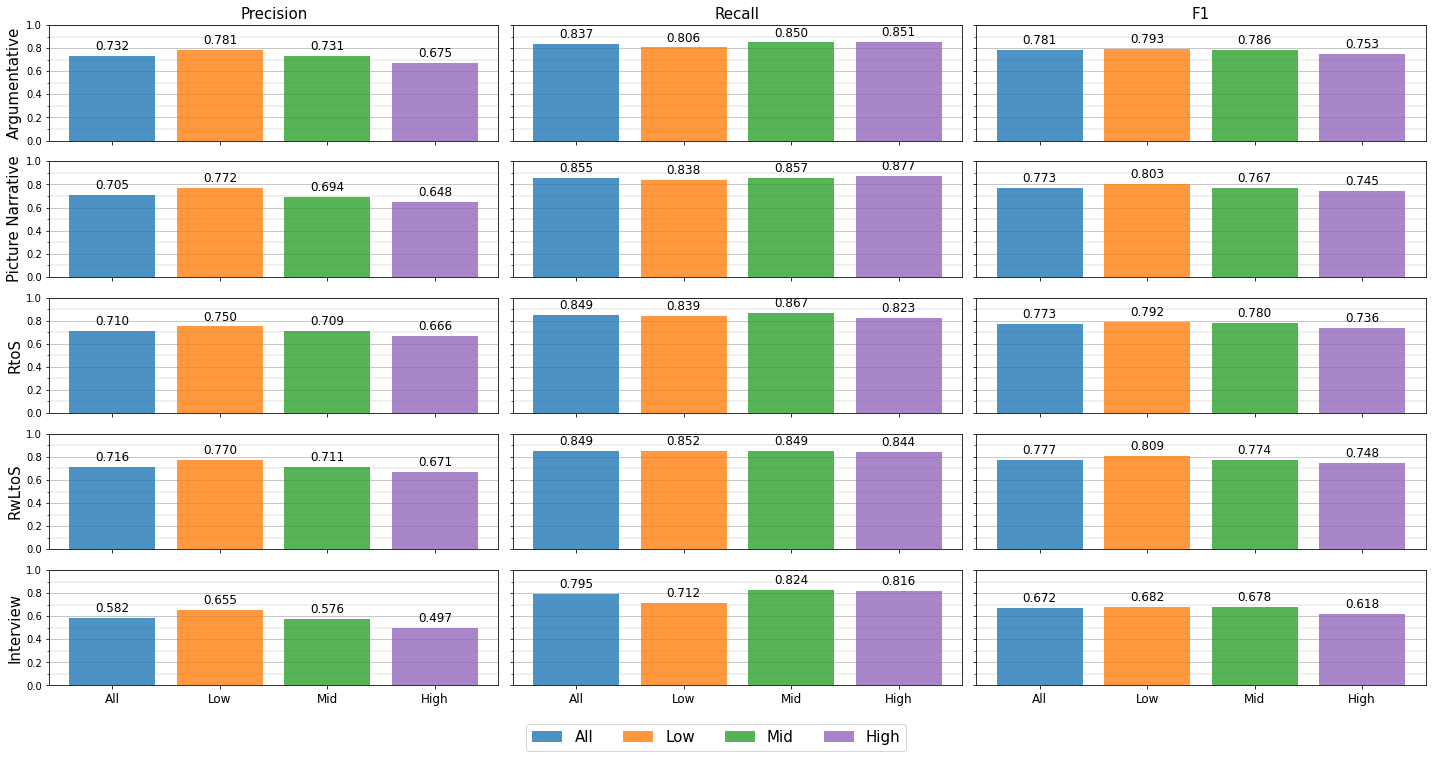

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

metrics = {"P_mcp": "Precision", "R_mcp": "Recall", "F1_mcp": "F1"}
groups = ["All", "Low", "Mid", "High"]

for col_id, metrix in enumerate(metrics.keys()):
    for row_id, task in enumerate(TASK):
        ax = axes[row_id][col_id]

        ax, rects = draw_cfmx_bar_plot(df_cfmx_pl, task, metrix, ax=ax)

        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(groups, fontsize=12)

        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.grid(which="major", axis="y", lw=0.7)
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.grid(which="minor", axis="y", lw=0.4)
        ax.set_axisbelow(True)

        if col_id == 0:
            ax.set_ylabel(TASK_2_REPORTNAME[task], fontsize=15)
        else:
            ax.tick_params(labelleft=False)

        if row_id == 0:
            ax.set_title(metrics[metrix], fontsize=15)

        if row_id < len(TASK) - 1:
            ax.tick_params(labelbottom=False)

groups = ["All", "Low", "Mid", "High"]
fig.legend(
    rects, groups, loc="upper center", bbox_to_anchor=(0.5, 0.0), 
    ncol=4, handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15
)

fig.tight_layout()
plt.show()

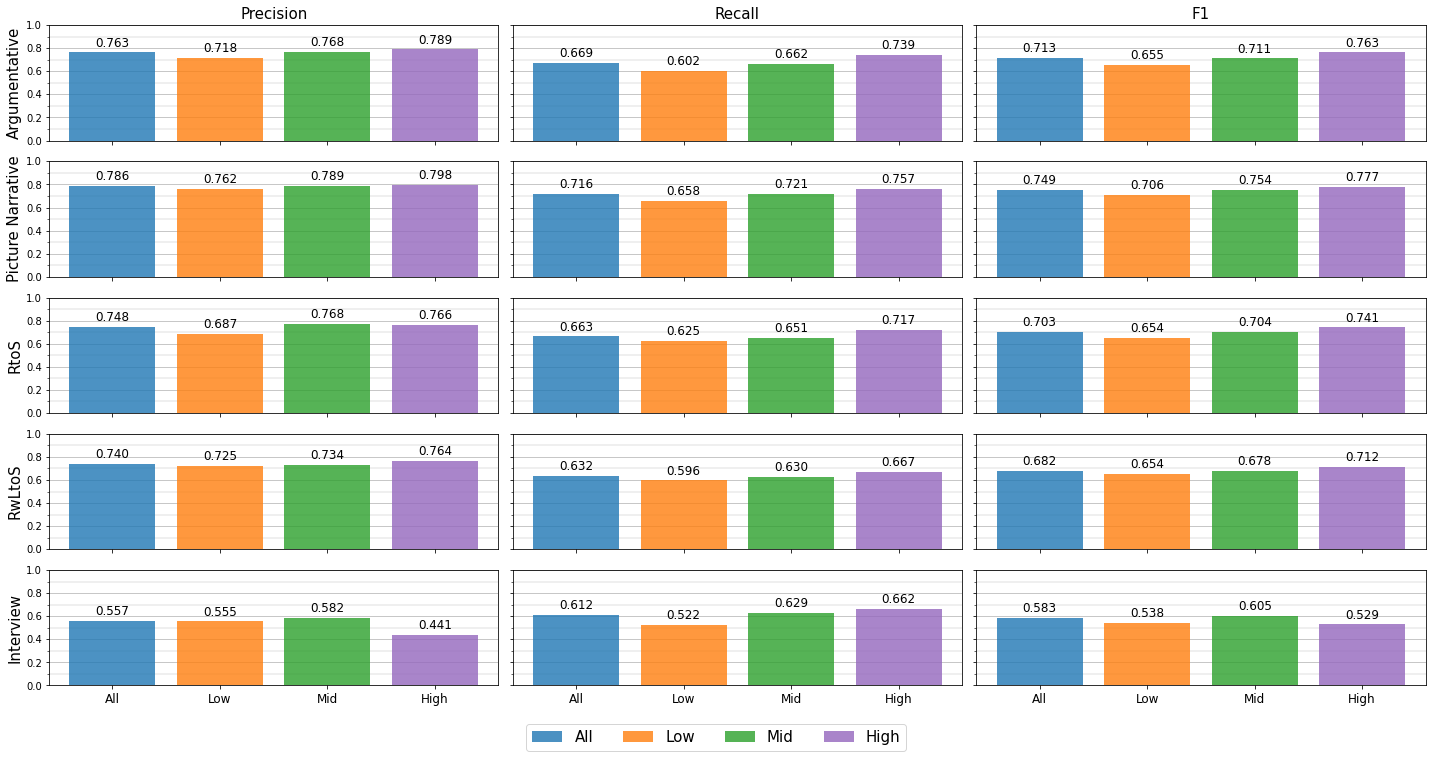

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))

metrics = {"P_ecp": "Precision", "R_ecp": "Recall", "F1_ecp": "F1"}
groups = ["All", "Low", "Mid", "High"]

for col_id, metrix in enumerate(metrics.keys()):
    for row_id, task in enumerate(TASK):
        ax = axes[row_id][col_id]

        ax, rects = draw_cfmx_bar_plot(df_cfmx_pl, task, metrix, ax=ax)

        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(groups, fontsize=12)

        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.grid(which="major", axis="y", lw=0.7)
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
        ax.grid(which="minor", axis="y", lw=0.4)
        ax.set_axisbelow(True)

        if col_id == 0:
            ax.set_ylabel(TASK_2_REPORTNAME[task], fontsize=15)
        else:
            ax.tick_params(labelleft=False)

        if row_id == 0:
            ax.set_title(metrics[metrix], fontsize=15)

        if row_id < len(TASK) - 1:
            ax.tick_params(labelbottom=False)

groups = ["All", "Low", "Mid", "High"]
fig.legend(
    rects, groups, loc="upper center", bbox_to_anchor=(0.5, 0.0), 
    ncol=4, handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15
)

fig.tight_layout()
plt.show()

## 4. Peasron's Correlation Coefficients

In [13]:
df_pcc = pd.read_csv(DATA_DIR / "correlation_all_results_mask_RtoS2055.csv")

In [14]:
def draw_pcc_horizontal_bar_plots(
    df_pcc: pd.DataFrame,
    uf_measure: str,
    n_groups: int=4,
    thresholds: Dict[str, tuple]={
        "weak": (0.2, 0.4), 
        "moderate": (0.4, 0.7), 
        "strong": (0.7, 1.0)
    },
    ax: Optional[plt.Axes] =None
) -> plt.Axes:
    if ax is None:
        ax = plt.axes()

    colors = []
    for i in range(n_groups):
        tab20_color_id = 2 * i
        if tab20_color_id > 5:
            tab20_color_id += 2
        colors.append(COLOR_MAP(tab20_color_id))
    
    strength_2_color = {
        "weak": "lightblue",
        "moderate": "lightsalmon",
        "strong": "yellowgreen"
    }
    for strength, threshold in thresholds.items():
        x_min, x_max = threshold
        ax.axvspan(
            x_min, x_max, color=strength_2_color[strength], alpha=0.2, zorder=1
        )
        # TODO: strength の文字を挿入

    mask_measure = (df_pcc["UF measure"] == uf_measure)
    for y, task in enumerate(reversed(TASK), start=1):
        mask_task = (df_pcc["task"] == task)
        df_pcc_mask = df_pcc[mask_task & mask_measure]

        pccs = df_pcc_mask["r"].to_numpy()
        minus_pccs = pccs - df_pcc_mask["lower"].to_numpy()
        mask_lower_than_zero = ((pccs - minus_pccs) < 0.0)
        minus_pccs[mask_lower_than_zero] = pccs[mask_lower_than_zero]
        plus_pccs = df_pcc_mask["upper"].to_numpy() - pccs
        
        n = len(pccs) # n = 4
        width = 0.8 / n # width = 0.2

        if n % 2 == 0:
            delta = (n / 2) * width + (0.5 / n) # delta = 2 * 0.2 + 0.25 = 0.4 + 0.25 = 0.65
        else: 
            delta = (n / 2 + 0.5) * width

        rects = []
        for i, r in enumerate(pccs):
            delta -= width # delta = -0.425, -0.225, -0.025, 0.225
            xerr = np.vstack([minus_pccs[i], plus_pccs[i]])

            p1 = ax.errorbar(
                r, y + delta, xerr=xerr, 
                fmt="o", lw=1.5, capsize=4, 
                capthick=1.4, color=colors[i],
                zorder=2    
            )
            rects.append(p1)

    ax.set_yticks(range(1, len(TASK) + 1))
    ax.set_yticklabels([TASK_2_REPORTNAME[task] for task in reversed(TASK)])

    ax.set_xticks(np.arange(0.0, 1.1, 0.1))

    return ax, rects

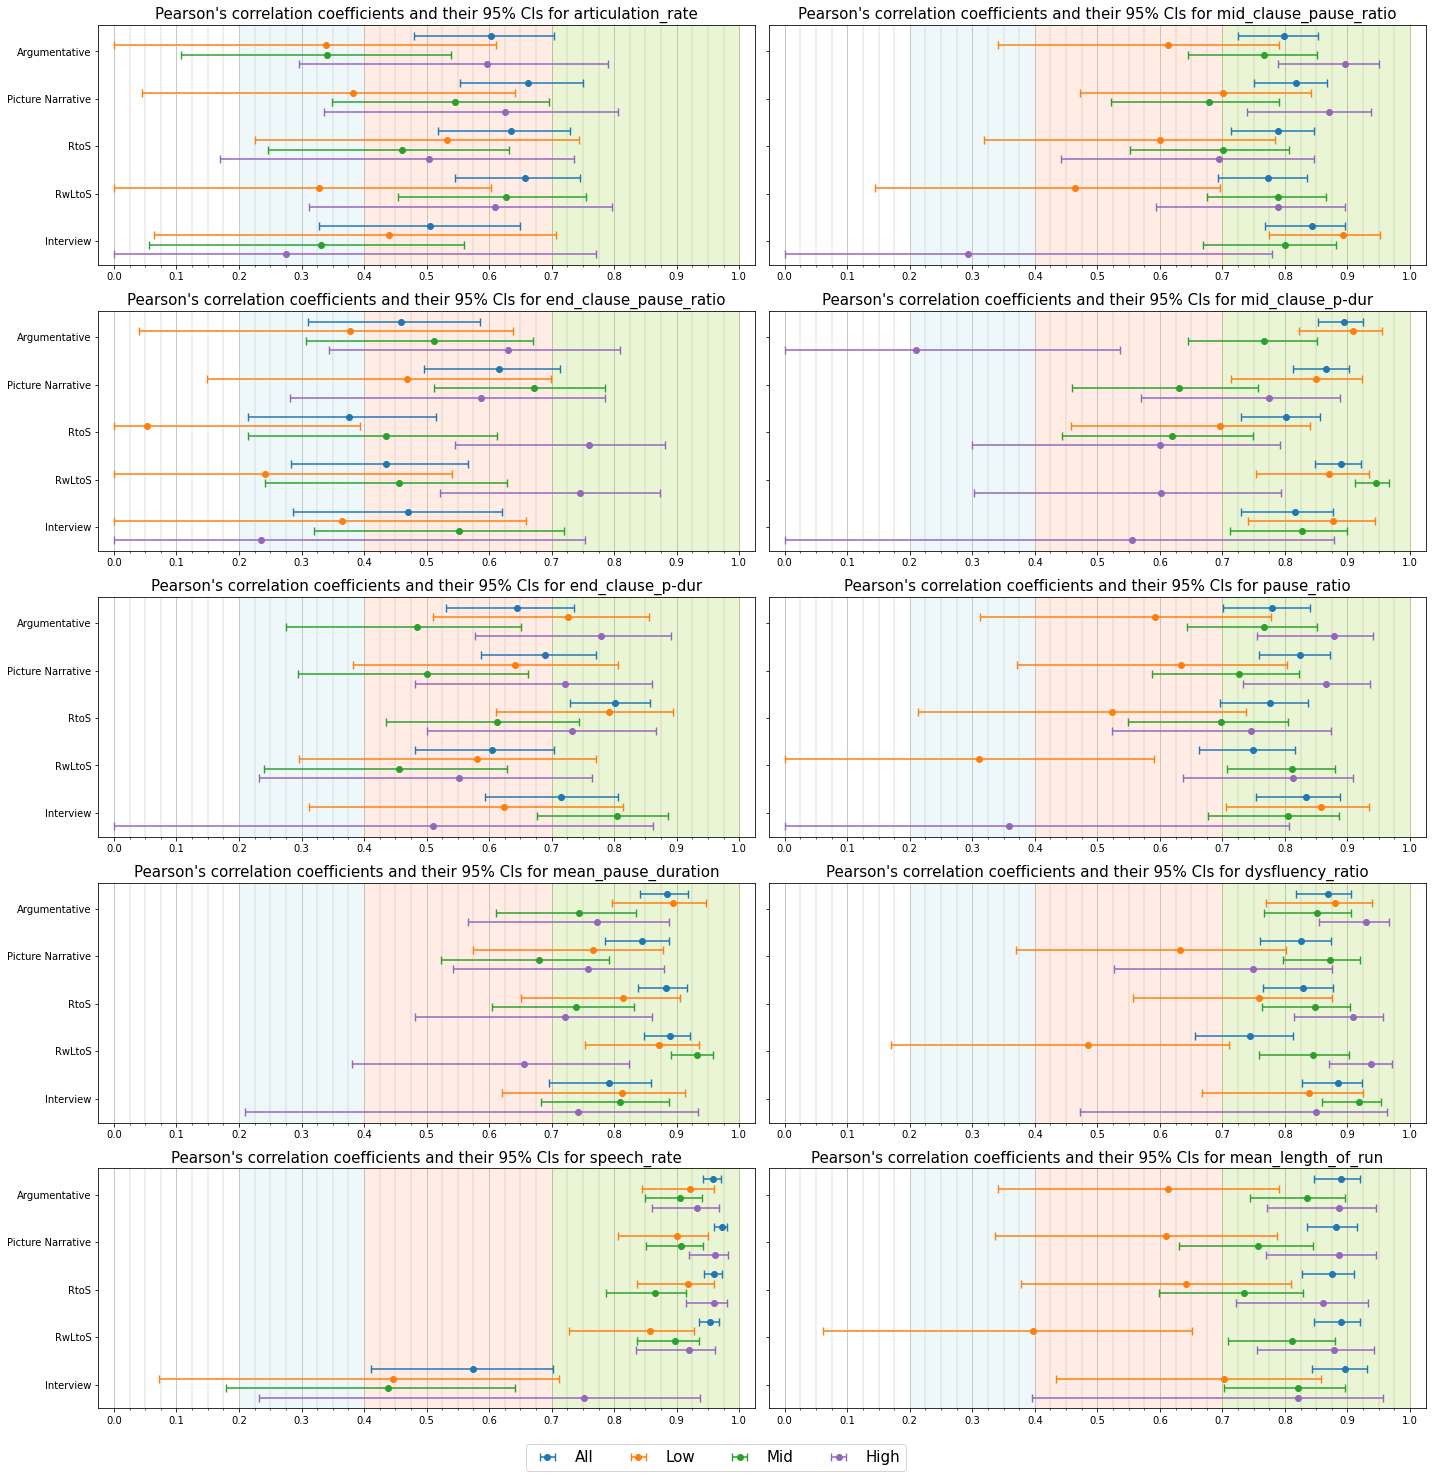

In [15]:
n_measures = len(TARGET_UF_MEASURES)

fig, axes = plt.subplots(nrows=(n_measures + 1) // 2, ncols=2, figsize=(20, 20))
for i, measure in enumerate(TARGET_UF_MEASURES):
    row_id = i // 2
    col_id = i % 2

    ax = axes[row_id][col_id]
    ax, rects = draw_pcc_horizontal_bar_plots(df_pcc, uf_measure=measure, ax=ax)

    ax.set_xlim(-0.025, 1.025)
    ax.grid(which="major", axis="x", lw=0.7)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    ax.grid(which="minor", axis="x", lw=0.4)
    ax.set_axisbelow(True)

    ax.set_title(f"Pearson's correlation coefficients and their 95% CIs for {measure}", fontsize=15)

    if col_id == 1:
        ax.tick_params(labelleft=False)
    # if row_id < (n_measures + 1) // 2 -1:
    #     ax.tick_params(labelbottom=False)

groups = ["All", "Low", "Mid", "High"]
fig.legend(
    rects, groups, loc="upper center", bbox_to_anchor=(0.5, 0.0), 
    ncol=4, handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15
)

fig.tight_layout()
plt.show()

In [16]:
def draw_pcc_line_graph(
    df_pcc: pd.DataFrame,
    uf_measure: str,
    n_tasks: int=5,
    thresholds: Dict[str, tuple]={
        "weak": (0.25, 0.4), 
        "moderate": (0.4, 0.6), 
        "strong": (0.6, 1.0)
    },
    ax: Optional[plt.Axes] =None
) -> plt.Axes:
    if ax is None:
        ax = plt.axes()

    colors = []
    for i in range(n_tasks):
        tab20_color_id = 2 * i
        if tab20_color_id > 5:
            tab20_color_id += 2
        colors.append(COLOR_MAP(tab20_color_id))
    
    strength_2_color = {
        "weak": "lightblue",
        "moderate": "lightsalmon",
        "strong": "yellowgreen"
    }
    for strength, threshold in thresholds.items():
        x_min, x_max = threshold
        ax.axhspan(
            x_min, x_max, color=strength_2_color[strength], alpha=0.4, zorder=1
        )
        # TODO: strength の文字を挿入

    mask_measure = (df_pcc["UF measure"] == uf_measure)
    mask_pf = (df_pcc["PF"] != "All")
    rects = []

    width = 0.1 / n_tasks # width = 0.16

    if n_tasks % 2 == 0:
        delta = -(n_tasks / 2) * width - (0.5 / n_tasks) 
    else: 
        delta = -(n_tasks / 2 - 0.5) * width # delta = -(2.5 - 0.5) * 0.16 = -0.32

    for i, task in enumerate(TASK):
        mask_task = (df_pcc["task"] == task)
        df_pcc_mask = df_pcc[mask_task & mask_measure & mask_pf]

        pccs = df_pcc_mask["r"].to_numpy()
        minus_pccs = pccs - df_pcc_mask["lower"].to_numpy()
        mask_lower_than_zero = ((pccs - minus_pccs) < 0.0)
        minus_pccs[mask_lower_than_zero] = pccs[mask_lower_than_zero]
        plus_pccs = df_pcc_mask["upper"].to_numpy() - pccs

        x = np.arange(len(pccs)) + delta

        rect = ax.plot(
            x, pccs, lw=1.5, color=colors[i], zorder=2
        )
        rects.append(rect[0])

        yerr = np.vstack([minus_pccs, plus_pccs])
        ax.errorbar(
            x, pccs, yerr=yerr, 
            fmt="o", lw=1.5, capsize=4, 
            capthick=1.4, color=colors[i],
            zorder=2    
        )

        delta += width # -0.32, -0.16, 0.00, 0.16, 0.32
        
    return ax, rects

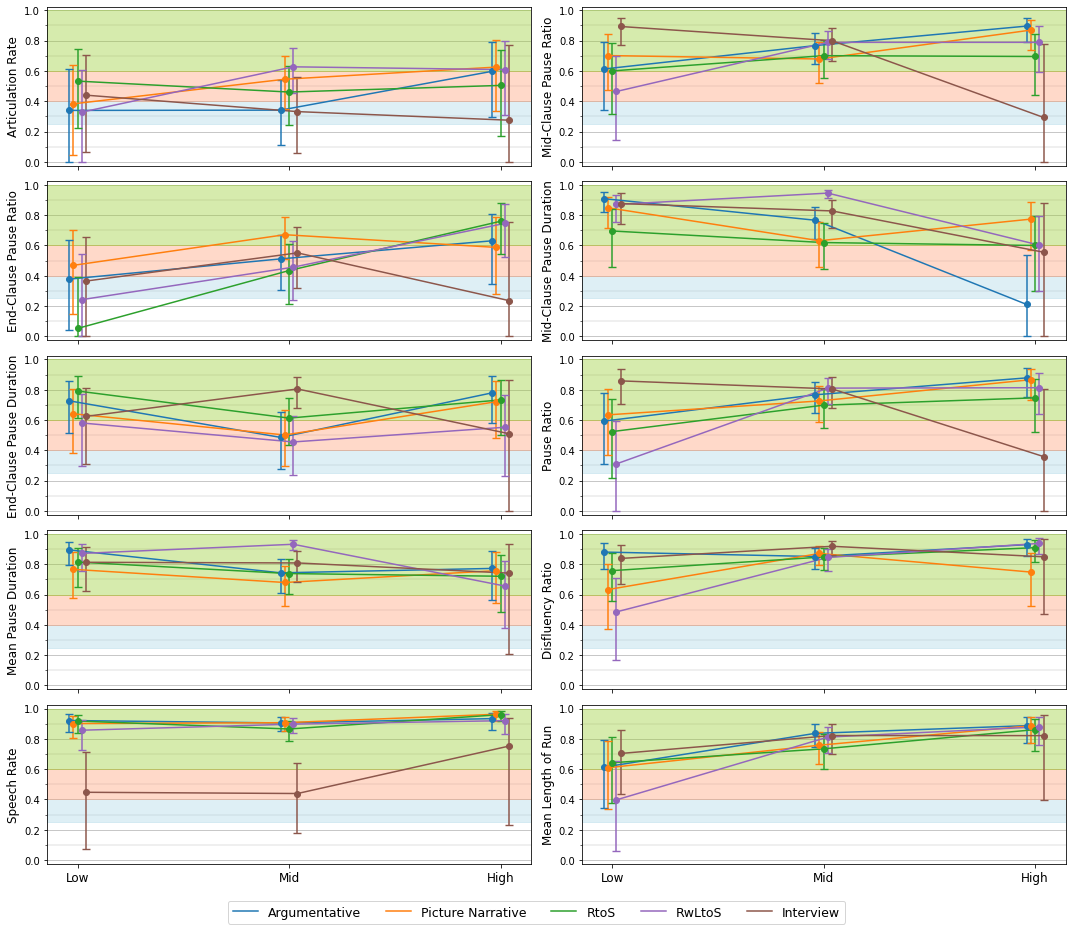

In [17]:
n_measures = len(TARGET_UF_MEASURES)

fig, axes = plt.subplots(nrows=(n_measures + 1) // 2, ncols=2, figsize=(15, 12.5))
for i, measure in enumerate(TARGET_UF_MEASURES):
    row_id = i // 2
    col_id = i % 2

    ax = axes[row_id][col_id]
    ax, rects = draw_pcc_line_graph(df_pcc, uf_measure=measure, ax=ax)

    ax.set_xticks([0, 1, 2])
    ax.set_yticks(np.arange(0.0, 1.2, 0.2))

    ax.set_ylim(-0.025, 1.025)

    ax.grid(which="major", axis="y", lw=0.7)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.grid(which="minor", axis="y", lw=0.4)
    ax.set_axisbelow(True)

    ax.set_ylabel(f"{MEEASURE_2_REPORTNAME[measure]}", fontsize=12)

    # if col_id == 1:
    #     ax.tick_params(labelleft=False)
        
    if row_id < (n_measures + 1) // 2 -1:
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xticklabels(["Low", "Mid", "High"], fontsize=12)

task_names = [TASK_2_REPORTNAME[task] for task in TASK]
fig.legend(
    rects, task_names, loc="upper center", bbox_to_anchor=(0.5, 0.0), 
    ncol=len(TASK), handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=12.5
)

fig.tight_layout()
plt.show()

## 5. Dominance Analyses

In [18]:
df_relative_imp = pd.read_csv(DATA_DIR / "dominance_analysis_all_results.csv", index_col=0)

task_2_trial = {
    "Arg_Oly": "3 trial", 
    "Cartoon": "4 trial", 
    "RtSwithoutRAA": "1 trial", 
    "RtSwithRAA": "0 trial", 
    "WoZ_Interview": "3 trial"    
}

In [19]:
def draw_relimp_bar_plot(
        df_relative_imp: pd.DataFrame,
        task: str,
        trial: str,
        method: str,
        facet: str="Rater",
        target_imp: str="Percentage Relative Importance",
        ax: Optional[plt.Axes] =None
) -> plt.Axes:
    if ax is None:
        ax = plt.axes()

    mask_task = (df_relative_imp["task"] == task)
    mask_trial = (df_relative_imp["name"] == trial)
    mask_method = (df_relative_imp["method"] == method)
    mask_facet = (df_relative_imp["facet"] == facet)
    mask = mask_task & mask_trial & mask_method & mask_facet
    
    df_relative_imp_mask = df_relative_imp[mask].sort_values(target_imp, ascending=True)
    relative_imp = df_relative_imp_mask[target_imp].to_numpy()
    uf_measures = [MEEASURE_2_REPORTNAME[measure] for measure in df_relative_imp_mask.index.to_numpy()]
    x = np.arange(len(relative_imp))

    rects = ax.barh(
        x, relative_imp, #width=0.8, 
        align="center", alpha=0.8
    )

    ax.set_yticks(x)
    #ax.set_yticklabels(uf_measures, rotation=45, ha="right")
    ax.set_yticklabels(uf_measures, fontsize=10)

    for imp, y in zip(relative_imp, x):
        ax.annotate(
            f"{imp:.03f}",
            xy=(imp + (imp * 0.01), y),
            # xytext=(0, 3),
            # textcoords="offset points",
            va="center",
            fontsize=12
        )

    return ax, rects

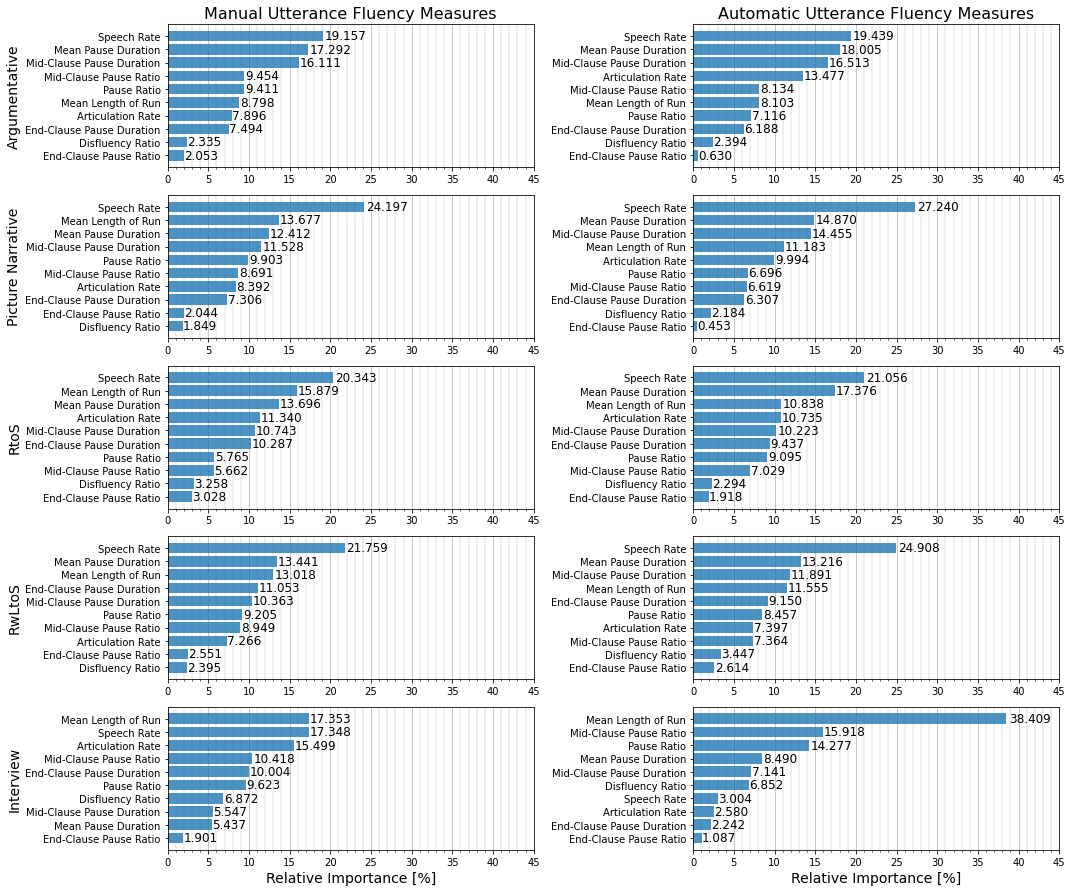

In [20]:
fig, axes = plt.subplots(nrows=(n_measures + 1) // 2, ncols=2, figsize=(15, 12.5))
for row_id, task in enumerate(TASK):
    for col_id, method in enumerate(["manual", "auto"]):
        ax = axes[row_id][col_id]
        ax, _ = draw_relimp_bar_plot(df_relative_imp, task, task_2_trial[task], method, ax=ax)#, target_imp="Total Dominance")
        
        # ax.set_xticks(np.arange(0.00, 0.27, 0.04))
        # ax.set_xlim(0.00, 0.26)
        ax.set_xticks(np.arange(0.00, 46.00, 5))
        ax.set_xlim(0.00, 45.00)

        ax.grid(which="major", axis="x", lw=0.7)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
        ax.grid(which="minor", axis="x", lw=0.4)
        ax.set_axisbelow(True)

        if row_id == 0:
            if method == "auto":
                method = "automatic"
            ax.set_title(f"{method.capitalize()} Utterance Fluency Measures", fontsize=16)
    
    axes[row_id][0].set_ylabel(f"{TASK_2_REPORTNAME[task]}", fontsize=14)

axes[row_id][0].set_xlabel("Relative Importance [%]", fontsize=14)
axes[row_id][1].set_xlabel("Relative Importance [%]", fontsize=14)

fig.tight_layout()
plt.show()